In [250]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Import Data

In [265]:
mcu = pd.read_csv("./data/mcu.csv")

min_line_count = 150

is_main_character = mcu["character"].value_counts() > min_line_count
is_main_character = is_main_character.rename("is main character", axis=0)

main_character_rows = is_main_character[mcu["character"]]
main_character_rows = main_character_rows.reset_index(drop=True)

mcu = mcu[main_character_rows]

y = mcu["character"].to_numpy().astype(str)
X = mcu["line"].to_numpy().astype(str)

X, y

(array(['Good sport.  Have fun?',
        'This thing on?  Hey, Ms. Potts. Pep.  If you find this recording, don’t post it on social media. It’s going to be a real tearjerker.',
        'I don’t know if you’re ever going to see these.  I don’t even know if you’re still...God, I hope so. Today’s day twenty-one, no...twenty- two.',
        ...,
        'What’s boring is when you roll your eyes like that at me and make an exasperated sound like I’m an old, boring, stupid idiot.',
        'Now I know how Yondu felt.', 'Yondu.'], dtype='<U606'),
 array(['TONY STARK', 'TONY STARK', 'TONY STARK', ..., 'PETER QUILL',
        'PETER QUILL', 'PETER QUILL'], dtype='<U12'))

## Train Test Split

In [266]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_examples_by_class = pd.DataFrame(y_train)[0].value_counts()
test_examples_by_class = pd.DataFrame(y_test)[0].value_counts()

table = pd.DataFrame({"Training Examples": train_examples_by_class, 
                      "Testing Examples": test_examples_by_class})
table['total'] = table.sum(axis=1)
table.loc['total'] = table.sum()

table.fillna(0, inplace=True)
table = table.astype('int64')
table = table.sort_values(by='total', ascending=False)

table

,Training Examples,Testing Examples,total
total,2066,517,2583
TONY STARK,513,132,645
THOR,371,108,479
STEVE ROGERS,210,50,260
BRUCE BANNER,203,55,258
PETER QUILL,185,43,228
ROCKET,160,38,198
NATASHA,144,35,179
PEPPER POTTS,142,30,172
LOKI,138,26,164


## Model

In [267]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
import matplotlib.pyplot as plt

model = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()), 
                  ('clf', MultinomialNB())])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__binary': [True, False],
              'vect__stop_words': [None, 'english'],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [10,1,1e-1, 1e-2, 1e-3, 1e-4]}

gs_clf = GridSearchCV(model, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

yhat = gs_clf.predict(X_test)

print('accuracy: ', np.sum(yhat==y_test) / len(yhat))
print(gs_clf.best_params_)

accuracy:  0.31721470019342357
{'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__binary': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


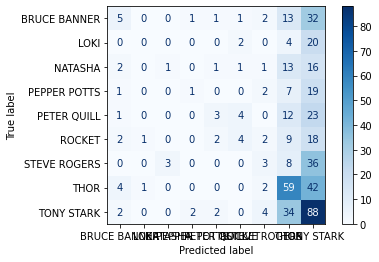

In [268]:
from sklearn.metrics import plot_confusion_matrix
plot = plot_confusion_matrix(gs_clf, X_test, y_test,
                             values_format = 'd',
                             cmap=plt.cm.Blues)